<a href="https://colab.research.google.com/github/diascarolina/project-icu-prediction/blob/main/notebooks/02_machine_learning_and_conclusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 - Clinical Data to Assess Diagnosis
# Part II - Machine Learning and Conclusion

<p align="center">
  <img width="700" src="https://i.imgur.com/wxaTMWn.png">
</p>

- Click [here to go back to Part 1 in Google Colab](https://colab.research.google.com/drive/1GbV_StVWhE5GUlYblbrWsJWzcRP_Dq7f?usp=sharing).

- [Project Repository: ICU Prediction](https://github.com/diascarolina/project-icu-prediction)

In this part, we'll finally start predicting the ICU admission for COVID-19 patients.

For this, we use some machine lerning models and check various metrics in order to compare them and choose the best model for our problem.

# Table of Contents

1. [How was this notebook organized](#orga)

2. [Libraries & Configurations](#libs)

3. [Functions](#funcs)

4. [Where did this **data** come from? What kind of **information** do we have in it?](#data)

5. [How will the data be **split** between **train** and **test**?](#split)

6. [What metric should we choose to start modelling?](#metric)

    6.1. [Model 1: Dummy Model](#dummy)

    6.2. [Model 2: Lazy Classifier](#lazy)

    6.3. [Model 3: RandomForestClassifier](#random)

    6.4. [Model 4: LGBMClassifier](#lgbm)

    6.5. [Model 5: AdaBoostClassifier](#abc)

    6.6. [Model 6: Logistic Regression](#logit)

    6.7. [Model 7: XGBoostClassifier](#xgboost)

7. [Best Models and Validations](#best)

    7.1. [Models Summary](#summ)

    7.2. [Feature Importance](#feat)

    7.3. [ICU Prediction](#icu)

8. [What can we **conclude** from this project?](#conc)

9. [Going Forward...](#next)

10. [References](#refs)

11. [Contacts](#cont)

<a name="orga"></a>
# 1 How was this notebook organized?

For this part, we have the following approach:

![machine learning steps](https://i.imgur.com/BLDhdVY.png)

So, the data we have is the cleaned data from our previous notebook. We'll do a quick recheck to see if everything's in order. Then we will begin with a dummy model to serve as a baseline, followed by the library Lazy Predict, used to test various models and to choose the best from them.

After we choose our candidates, we begin tuning the models and their hyperparameters in order to improve our metrics. But what metrics will we use? We'll also take a look at that.

Finally, we will choose the best model (or models) that helps us better solve our problem at hand: ICU prediction for COVID-19 patients.

Last but not least, we'll see our conclusions about this project and what can be improved and learned from this problem.

<a name="libs"></a>
# 2 Libraries & Configurations

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score

from sklearn.metrics import roc_curve, plot_roc_curve
from sklearn.metrics import precision_recall_curve, f1_score, auc

import lightgbm as lgb
from xgboost import XGBClassifier

# uncomment to install the library
#!pip3 install lazypredict
from lazypredict.Supervised import LazyClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# defining some colors
GRAY1, GRAY2, GRAY3 = '#231F20', '#414040', '#555655'
GRAY4, GRAY5, GRAY6 = '#646369', '#76787B', '#828282'
BLUE1, BLUE2, BLUE3, BLUE4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
RED1, RED2 = '#C3514E', '#E6BAB7'
GREEN1, GREEN2 = '#0C8040', '#9ABB59'

# charts fonts
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.bf'] = 'Arial:bold'
plt.rcParams['mathtext.it'] = 'Arial:italic'

In [ ]:
# let's set a seed to be used throughout the notebook
rs = 84097
np.random.seed(rs)

<a name="funcs"></a>
# 3 Functions

Some useful functions that will be used later on but they don't really have a good place to stay inside the bulk of the notebook itself.

And I prefer to keep them here instead of a separate script for now.

In [ ]:
def run_cv_model(model, data:pd.DataFrame, n_splits:int, n_repeats:int):
    '''
    This function runs a previously instantiated models using a 
    cross-validation approach.

    Input:
    model -> a previously instatiated machine learning model

    data -> a pandas dataframe

    n_splits -> an integer representing the number of times we'll split our data

    n_repeats -> an integer representing the number of times our cross-validation will be repeated

    Output:
    The results of a print function detailing the Average AUC scores from the runs and
    the 95% confidence interval for the given data.
    '''
    np.random.seed(rs)
    
    data = data.sample(frac = 1).reset_index(drop = True)
    y = data['ICU']
    X = data.drop(['ICU'], axis = 1)
        
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats)
    results = cross_validate(model, X, y, cv = cv, scoring = 'roc_auc', return_train_score = True)
    
    avg_auc = np.mean(results['test_score'])
    avg_auc_train = np.mean(results['train_score'])
    auc_std = np.std(results['test_score'])
    
    print(f'Average AUC Score: {avg_auc}')
    print(f'AUC 95% Confidence Interval: {avg_auc - 2 * auc_std} to {avg_auc + 2 * auc_std}')

In [ ]:
def organize_metrics(model_initials:str):
    '''
    Function used to create a list with all the model's calculated metrics,
    for organization purposes. The naming of the metrics must be consistent
    throughout all notebook.

    Input:
    model_initials -> the chosen initials for the machine learning model

    Output:
    metrics -> a list containing the model's calculated metrics
    '''
    metrics = [
               round(eval(model_initials + '_accuracy'), 2),
               round(eval(model_initials + '_avg_auc'), 2),
               round(eval(model_initials + '_dict')['0']['f1-score'], 2),
               round(eval(model_initials + '_dict')['1']['f1-score'], 2),
               round(eval(model_initials + '_dict')['0']['precision'], 2),
               round(eval(model_initials + '_dict')['1']['precision'], 2),
               round(eval(model_initials + '_dict')['0']['recall'], 2), 
               round(eval(model_initials + '_dict')['1']['recall'], 2)
              ]

    return metrics

In [ ]:
# adapted from: https://stackoverflow.com/questions/59839782/confusion-matrix-font-size

def confusion_matrix_plot(y_pred, title = 'Confusion Matrix', cmap = 'GnBu'):
    '''
    Plots a confusion matrix. The difference from the scikit-learn function to plot
    the confusion matrix is that here we can increase the fontsize when need.

    Input:
    y_pred -> the prediction obtained from the model
    title -> the title of the chart, default is "Confusion Matrix"
    cmap -> the colormap used, default is "Blues"

    Output:
    a chart with the customized confusion matrix
    '''
    cm = confusion_matrix(y_test, y_pred)
    classes = ['Not ICU', 'ICU']
    plt.figure(figsize = (10, 7))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0, fontsize = 15)
    plt.yticks(tick_marks, classes, rotation = 90, fontsize = 15)
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], ha = 'center', fontsize = 15,
                 color = 'white' if cm[i, j] > thresh else 'black')
        plt.tight_layout()
        plt.ylabel('True Label', fontsize = 20)
        plt.xlabel('Predicted Label', fontsize = 20)

<a name="data"></a>
# 4 Where did this **data** come from? What kind of **information** do we have in it?

Here we'll use the cleaned and final dataset obtained from the first notebook.

The downloaded data was uploaded to Github and it's available [here](https://raw.githubusercontent.com/diascarolina/data-science-bootcamp/main/data/final_data.csv).

We ended up with:

- 352 rows, each representing a patient;
- 98 features
- 1 target variable: ICU



In [ ]:
data_url = 'https://raw.githubusercontent.com/diascarolina/data-science-bootcamp/main/data/final_data.csv'
data = pd.read_csv(data_url)

In [ ]:
data.head()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_DIFF,FFA_MEDIAN,FFA_DIFF,GGT_MEDIAN,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,INR_MEDIAN,...,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_DIFF,TGO_MEDIAN,TGO_DIFF,TGP_MEDIAN,TGP_DIFF,TTPA_MEDIAN,TTPA_DIFF,UREA_MEDIAN,UREA_DIFF,DIMER_MEDIAN,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,RESPIRATORY_RATE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
0,1,5,0,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.61,-1.00,-1.00,-1.00,-1.00,-1.00,-0.32,-1.00,-0.32,-1.00,-0.94,-1.00,-1.00,-1.00,0.18,-1.00,-0.87,-1.00,-0.74,-1.00,-0.95,-1.00,-0.89,-1.00,0.09,-1.00,-1.00,-0.93,...,-1.00,0.36,-1.00,-0.54,-1.00,-0.52,-1.00,0.94,-1.00,0.35,-1.00,-0.03,-1.00,-1.00,-1.00,-0.99,-1.00,-0.83,-1.00,-0.84,-1.00,-0.99,-1.00,0.09,-0.23,-0.28,-0.59,-0.29,0.74,-0.50,-0.25,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1
1,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.61,-1.00,-1.00,-1.00,-1.00,-1.00,-0.32,-1.00,-0.32,-1.00,-0.94,-1.00,-1.00,-1.00,0.36,-1.00,-0.91,-1.00,-0.74,-1.00,-0.96,-1.00,-0.78,-1.00,0.14,-1.00,-1.00,-0.96,...,-1.00,0.36,-1.00,-0.40,-1.00,-0.70,-1.00,0.94,-1.00,0.35,-1.00,0.09,-1.00,-1.00,-1.00,-0.99,-1.00,-0.85,-1.00,-0.84,-1.00,-0.98,-1.00,-0.49,-0.69,-0.05,-0.65,0.36,0.94,-0.71,-0.44,-0.55,-0.53,-0.60,-0.76,-1.00,-0.96,-0.75,-0.96,1
2,0,3,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,-0.26,-1.00,-1.00,-1.00,-1.00,-1.00,-0.32,-1.00,-0.32,-1.00,-0.97,-1.00,-1.00,-1.00,0.33,-1.00,-0.97,-1.00,-0.19,-1.00,-0.32,-1.00,-0.89,-1.00,-0.20,-1.00,-1.00,-0.96,...,-1.00,0.36,-1.00,-0.56,-1.00,-0.78,-1.00,0.94,-1.00,0.58,-1.00,0.20,-1.00,-0.99,-1.00,-0.96,-1.00,-0.85,-1.00,-0.94,-1.00,-0.98,-1.00,0.01,-0.37,-0.53,-0.46,-0.29,0.68,-0.36,-0.30,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,0
3,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.61,-1.00,-1.00,-1.00,-1.00,-1.00,-0.32,-1.00,-0.32,-1.00,-0.94,-1.00,-1.00,-1.00,0.36,-1.00,-0.91,-1.00,-0.83,-1.00,-0.94,-1.00,-0.85,-1.00,0.36,-1.00,-1.00,-0.96,...,-1.00,0.36,-1.00,-0.46,-1.00,-0.59,-1.00,0.94,-1.00,0.35,-1.00,0.14,-1.00,-1.00,-1.00,-0.99,-1.00,-0.85,-1.00,-0.90,-1.00,-1.00,-1.00,0.33,-0.15,0.16,-0.59,0.29,0.87,-0.57,-0.08,-1.00,-0.88,-0.92,-0.88,-0.95,-0.98,-0.96,-0.98,0
4,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.61,-1.00,-1.00,-1.00,-1.00,-1.00,-0.32,-1.00,-0.32,-1.00,-0.94,-1.00,-1.00,-1.00,0.36,-1.00,-0.89,-1.00,-0.74,-1.00,-0.96,-1.00,-0.89,-1.00,0.29,-1.00,-1.00,-0.96,...,-1.00,0.36,-1.00,-0.29,-1.00,-0.67,-1.00,0.94,-1.00,0.35,-1.00,0.09,-1.00,-1.00,-1.00,-0.99,-1.00,-0.85,-1.00,-0.88,-1.00,-1.00,-1.00,-0.04,-0.54,-0.54,-0.53,-0.20,0.82,-0.43,-0.25,-0.83,-0.75,-0.98,-1.00,-0.98,-0.98,-0.99,-0.98,0


In [ ]:
data.shape

(352, 99)

In [ ]:
# just to be sure that we have no non-numeric values
(data.isin([np.nan, np.inf, -np.inf])).sum().sum()

0

We have the ```AGE_PERCENTIL``` as a categorical variable and each category is represented as a number. Seeing as all the other variables have numerical values between -1 and 1, it's better if we change this variable to follow this pattern. So, for each category we'll create a new column for them, with the values 1 if the row has that value, and 0 if not. This is called the One-Hot Enconding (or dummy, in statistics).

In [ ]:
data_ml = data.copy()
data_ml = pd.get_dummies(data_ml, columns = ['AGE_PERCENTIL'])

In [ ]:
data_ml.head()

,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_DIFF,FFA_MEDIAN,FFA_DIFF,GGT_MEDIAN,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,INR_MEDIAN,INR_DIFF,...,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_DIFF,TGO_MEDIAN,TGO_DIFF,TGP_MEDIAN,TGP_DIFF,TTPA_MEDIAN,TTPA_DIFF,UREA_MEDIAN,UREA_DIFF,DIMER_MEDIAN,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,RESPIRATORY_RATE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU,AGE_PERCENTIL_0,AGE_PERCENTIL_1,AGE_PERCENTIL_2,AGE_PERCENTIL_3,AGE_PERCENTIL_4,AGE_PERCENTIL_5,AGE_PERCENTIL_6,AGE_PERCENTIL_7,AGE_PERCENTIL_8,AGE_PERCENTIL_9
0,1,0,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.61,-1.00,-1.00,-1.00,-1.00,-1.00,-0.32,-1.00,-0.32,-1.00,-0.94,-1.00,-1.00,-1.00,0.18,-1.00,-0.87,-1.00,-0.74,-1.00,-0.95,-1.00,-0.89,-1.00,0.09,-1.00,-1.00,-0.93,-1.00,...,-1.00,-0.03,-1.00,-1.00,-1.00,-0.99,-1.00,-0.83,-1.00,-0.84,-1.00,-0.99,-1.00,0.09,-0.23,-0.28,-0.59,-0.29,0.74,-0.50,-0.25,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1,0,0,0,0,0,1,0,0,0,0
1,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.61,-1.00,-1.00,-1.00,-1.00,-1.00,-0.32,-1.00,-0.32,-1.00,-0.94,-1.00,-1.00,-1.00,0.36,-1.00,-0.91,-1.00,-0.74,-1.00,-0.96,-1.00,-0.78,-1.00,0.14,-1.00,-1.00,-0.96,-1.00,...,-1.00,0.09,-1.00,-1.00,-1.00,-0.99,-1.00,-0.85,-1.00,-0.84,-1.00,-0.98,-1.00,-0.49,-0.69,-0.05,-0.65,0.36,0.94,-0.71,-0.44,-0.55,-0.53,-0.60,-0.76,-1.00,-0.96,-0.75,-0.96,1,1,0,0,0,0,0,0,0,0,0
2,0,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,-0.26,-1.00,-1.00,-1.00,-1.00,-1.00,-0.32,-1.00,-0.32,-1.00,-0.97,-1.00,-1.00,-1.00,0.33,-1.00,-0.97,-1.00,-0.19,-1.00,-0.32,-1.00,-0.89,-1.00,-0.20,-1.00,-1.00,-0.96,-1.00,...,-1.00,0.20,-1.00,-0.99,-1.00,-0.96,-1.00,-0.85,-1.00,-0.94,-1.00,-0.98,-1.00,0.01,-0.37,-0.53,-0.46,-0.29,0.68,-0.36,-0.30,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.61,-1.00,-1.00,-1.00,-1.00,-1.00,-0.32,-1.00,-0.32,-1.00,-0.94,-1.00,-1.00,-1.00,0.36,-1.00,-0.91,-1.00,-0.83,-1.00,-0.94,-1.00,-0.85,-1.00,0.36,-1.00,-1.00,-0.96,-1.00,...,-1.00,0.14,-1.00,-1.00,-1.00,-0.99,-1.00,-0.85,-1.00,-0.90,-1.00,-1.00,-1.00,0.33,-0.15,0.16,-0.59,0.29,0.87,-0.57,-0.08,-1.00,-0.88,-0.92,-0.88,-0.95,-0.98,-0.96,-0.98,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.61,-1.00,-1.00,-1.00,-1.00,-1.00,-0.32,-1.00,-0.32,-1.00,-0.94,-1.00,-1.00,-1.00,0.36,-1.00,-0.89,-1.00,-0.74,-1.00,-0.96,-1.00,-0.89,-1.00,0.29,-1.00,-1.00,-0.96,-1.00,...,-1.00,0.09,-1.00,-1.00,-1.00,-0.99,-1.00,-0.85,-1.00,-0.88,-1.00,-1.00,-1.00,-0.04,-0.54,-0.54,-0.53,-0.20,0.82,-0.43,-0.25,-0.83,-0.75,-0.98,-1.00,-0.98,-0.98,-0.99,-0.98,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
data_ml.shape

(352, 108)

So in this ```data_ml``` dataset we end up with:
- 352 rows, one for each patient;
- 107 features and
- 1 target variable, the ```ICU```.

<a name="split"></a>
# 5 How will the data be split between **train** and **test**?

We have that our target variable is the ```ICU``` column. So let's set it as our ```y```.

In [ ]:
y = data_ml['ICU']
X = data_ml.drop(['ICU'], axis = 1)

Now, to split the data between train and test, we'll use the default value from the ```train_test_split``` function: 75% of the data to the train set and 25% to the test set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    random_state = rs)

# stratify = y: each set contains approximately the same percentage of the y target

In [ ]:
print(f'X train size: {len(X_train)} || y train size: {len(y_train)}')
print(f'X test size: {len(X_test)} || y train size: {len(y_test)}')

X train size: 264 || y train size: 264
X test size: 88 || y train size: 88


<a name="metric"></a>
# 6 What metric should we choose to start modelling?

One of the most difficult parts in creating a machine learning project is picking the best metric that better suits each problem.

In this case, our task is to predict admission to the ICU of confirmed COVID-19 cases.


**So let's think a little about it:**

In this case of ICU prediction, we want to be absolutely sure that we send the right patients for the ICU, so we need to get it right most of the time. This type of prediction is what we call **True Positive**, where we predict that a patient that needs to go to the ICU really goes to the ICU.

But we also have to think about not seending too many patients to the ICU when in fact they don't need to go, so as not to overwhelm the healthcare system with more patients than it can accomodate. That's why we always have to keep in mind the problem we are dealing with when modelling.

So we want to lower the number of patients that we predict as going to the ICU but in fact they don't need to go. This is called the **False Positives**, and we prefer a lower number of False Positives for this particular problems.

Another thing to take into consideration is the number of **False Negatives**, that is, when a patient needs to go to the ICU but we predict that the patient doesn't need to. This is something we want to avoid, because it could potentially lead to the patient's death, so it is an unacceptable error.

**To recap:**
- we want more True Positives (TP)
- less False Positives (FP)
- less False Negatives (FN)

Then, to the question of what metric to choose... In our case, our classes are considered balanced, so even the accuracy could be a good metric. But it doesn't take into account the number of TPs or FPs.

A good metric that takes into account TPs, FPs and FNs is the **F1-score**. It is defined as follows:

$$\text{F1-score} = 2\times\frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

where

$$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$$

and

$$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{True Negatives}}$$

So whenever the number of TPs increases, the precision also increases. And when the number of FNs increase, the precision decreases. All in all, the **F1-score** seems like a good metric for this problem, because it balances these types of errors, and it is the one that we will use, but we will keep an eye on other metrics such as **precision** and the **AUC**.


Source: [Tour of Evaluation Metrics for Classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)


<a name="dummy"></a>
## 6.1 Model 1: Dummy Model

First, we'll use a dummy model in order to have a baseline for our future models. This is a good practice when evaluating various machine learning models, as it acts as a minimum threshold of quality that of future models need in order to be considered useful.

The strategy we'll use for this dummy model is to predict all values as the same value of the most frequent target variable value. That will give us a certain accuracy that will be used to evaluate future models.

In [ ]:
# instantiate and fit the model
dummy_model = DummyClassifier(strategy = 'most_frequent')
dummy_model.fit(X_train, y_train)

# calculate model accuracy
y_prediction_dummy = dummy_model.predict(X_test)
dummy_accuracy = accuracy_score(y_test, y_prediction_dummy)
print(f'Accuracy of the Dummy Model: {dummy_accuracy}')

Accuracy of the Dummy Model: 0.5340909090909091


We will calculate the following metrics just for completeness sake, but their results are already expected since this is a well-behaved model.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


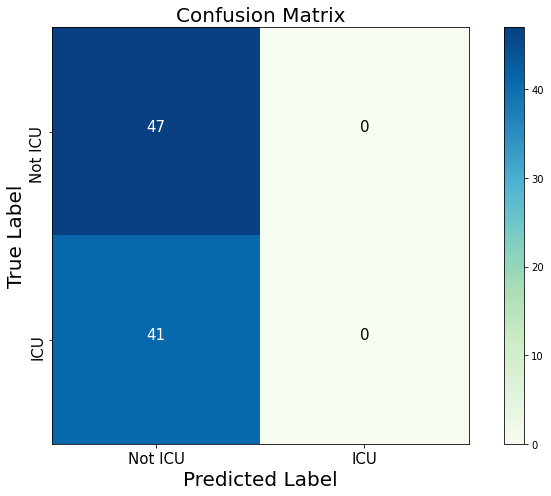

In [ ]:
confusion_matrix_plot(y_prediction_dummy)

As was said before, these were the expected values, because the model predicted only the 0 class (Not ICU). So it got all True Negatives and False Negatives, with no True Positives ot False Positives.

In [ ]:
# auc score of one prediction
prob_dummy = dummy_model.predict_proba(X_test)
dummy_auc = roc_auc_score(y_test, prob_dummy[:,1])
print(f'The AUC for the Dummy model is {dummy_auc}.')

The AUC for the Dummy model is 0.5.


In [ ]:
# again, this metric is not relevant here, but let's calculate it anyway
run_cv_model(dummy_model, data_ml, 5, 2)

Average AUC Score: 0.5
AUC 95% Confidence Interval: 0.5 to 0.5


In [ ]:
# just to keep it in a variable
dummy_avg_auc = 0.5

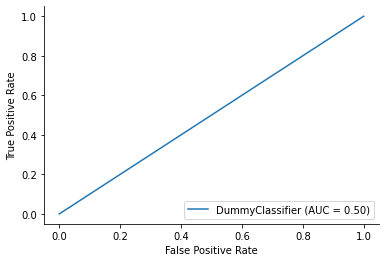

In [ ]:
plot_roc_curve(dummy_model, X_test, y_test)
sns.despine()
plt.show()

In [ ]:
dummy_dict = classification_report(y_test, y_prediction_dummy, output_dict = True)
print(classification_report(y_test, y_prediction_dummy))

              precision    recall  f1-score   support

           0       0.53      1.00      0.70        47
           1       0.00      0.00      0.00        41

    accuracy                           0.53        88
   macro avg       0.27      0.50      0.35        88
weighted avg       0.29      0.53      0.37        88



<a name="lazy"></a>
## 6.2 Model 2: Lazy Classifier

This is not a model _per se_, but it is a useful library used to quickly train various models and rank them by our chosen metric. This is important as a way of choosing some models in the beginning of the machine learning modelling part of our project.

In [ ]:
# instantiate and fit model
lc_model = LazyClassifier(verbose = 0,
                                 ignore_warnings = True,
                                 predictions = False,
                                 custom_metric = None)
models, predictions_lazy = lc_model.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [00:02<00:00, 13.33it/s]


In [ ]:
models.head(5)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.78,0.78,0.78,0.78,0.25
ExtraTreesClassifier,0.78,0.78,0.78,0.78,0.17
LGBMClassifier,0.76,0.76,0.76,0.76,0.08
AdaBoostClassifier,0.76,0.76,0.76,0.76,0.17
BaggingClassifier,0.76,0.75,0.75,0.76,0.08


The models chosen from the Lazy Predict library are:

- **RandomForestClassifier**
- **LGBMClassifer**
- **AdaBoostClassifier**

ExtraTreeClassifier will not be used because after testing it gave the same results as RandomForestClassifier. This happens because it uses the same method of modelling: random trees.

We'll also be using **LogisticRegression** and **XGBoostClassifier**. The former because it is the epitome of binary classification, and the former because it is widely used in many competitions for its great power in predicting.

<a name="random"></a>
## 6.3 Model 3: RandomForestClassifier

From the documentation:

> A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

Source: [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

### Default Model

Even though we already used this model with no tuning in the Lazy Predict library, it's important to check it again, because the mentioned library tends to pre-process the data before fitting and training, giving different results.

This is just a quick step, to act as a sanity check for our models.

In [ ]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train, y_train)

y_prediction_rfc = rfc_model.predict(X_test)
accuracy_score(y_test, y_prediction_rfc)

0.7386363636363636

### Tuned Model

I previously tested the ```GridSearchCV``` with other parameters, but limited the number of relevant parameters so as to reduce the computation time for the notebook.

In [ ]:
rfc_model = RandomForestClassifier()

params = {
    'n_estimators': [10, 50, 100, 250],
    'n_jobs': [-1],
    'random_state': [rs],
    'max_features': ['sqrt', 'auto', 'log2']
}


rfc_search = GridSearchCV(rfc_model,
                          params, 
                          scoring = 'roc_auc',
                          error_score = 'raise',
                          n_jobs = -1,
                          verbose = 0,
                          cv = 5)

rfc_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise', estimator=RandomForestClassifier(),
             n_jobs=-1,
             param_grid={'max_features': ['sqrt', 'auto', 'log2'],
                         'n_estimators': [10, 50, 100, 250], 'n_jobs': [-1],
                         'random_state': [84097]},
             scoring='roc_auc')

In [ ]:
rfc_search.best_params_

{'max_features': 'log2',
 'n_estimators': 100,
 'n_jobs': -1,
 'random_state': 84097}

In [ ]:
# refit the model with the improved parameters
rfc_model = rfc_search.best_estimator_
rfc_model.fit(X_train, y_train)

RandomForestClassifier(max_features='log2', n_jobs=-1, random_state=84097)

### Metrics

In [ ]:
y_prediction_rfc = rfc_model.predict(X_test)
rfc_accuracy = accuracy_score(y_test, y_prediction_rfc)
print(f'The accuracy for the RandomForestClassifier model is {rfc_accuracy}')

The accuracy for the RandomForestClassifier model is 0.7386363636363636


The accuracy is the same as the default model and less than the accuracy obtained from the Lazy Predict library.

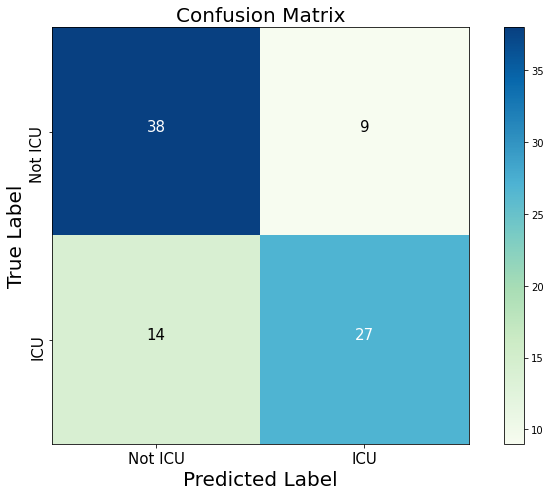

In [ ]:
confusion_matrix_plot(y_prediction_rfc)

In [ ]:
# auc from the model run only once
prob_rfc = rfc_model.predict_proba(X_test)
rfc_auc = roc_auc_score(y_test, prob_rfc[:,1])
print(f'The AUC for the RandomForestClassifier model is {rfc_auc}')

The AUC for the RandomForestClassifier model is 0.856772184743124


In [ ]:
# average auc using cross validation
run_cv_model(rfc_model, data_ml, 5, 2)

Average AUC Score: 0.7984824238113711
AUC 95% Confidence Interval: 0.685400958938143 to 0.9115638886845993


In [ ]:
# just to keep it in a variable
rfc_avg_auc = 0.7984824238113711

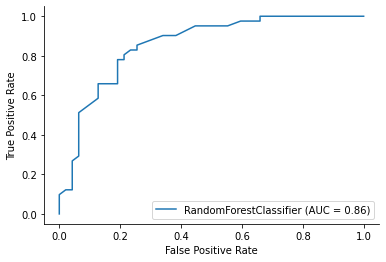

In [ ]:
plot_roc_curve(rfc_model, X_test, y_test)
sns.despine()
plt.show()

In [ ]:
rfc_dict = classification_report(y_test, y_prediction_rfc, output_dict = True)
print(classification_report(y_test, y_prediction_rfc))

              precision    recall  f1-score   support

           0       0.73      0.81      0.77        47
           1       0.75      0.66      0.70        41

    accuracy                           0.74        88
   macro avg       0.74      0.73      0.73        88
weighted avg       0.74      0.74      0.74        88



<a name="lgbm"></a>
## 6.4 Model 4: LGBMClassifier

From the documentation:

> Light GBM is a gradient boosting framework that uses tree based learning algorithm. Light GBM grows tree vertically while other algorithm grows trees horizontally.

_Source:_ [LGBMClassifier Documentation](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

### Default Model

In [ ]:
lgb_model = lgb.LGBMClassifier(objective = 'binary')
lgb_model.fit(X_train, y_train)

y_pred = lgb_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7272727272727273

### Tuned Model

In [ ]:
param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300, 400],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }

lgb_estimator = lgb.LGBMClassifier(objective='binary',
                                   num_boost_round = 2000,
                                   learning_rate = 0.01,
                                   metric = 'roc_auc')

gsearch = GridSearchCV(estimator = lgb_estimator,
                       param_grid = param_grid,
                       cv = 5)

lgb_model = gsearch.fit(X = X_train, y = y_train)

In [ ]:
gsearch.best_params_

{'lambda_l1': 1.5,
 'lambda_l2': 1,
 'min_data_in_leaf': 30,
 'num_leaves': 31,
 'reg_alpha': 0.1}

In [ ]:
lgb_model = gsearch.best_estimator_
lgb_model.fit(X_train, y_train)

LGBMClassifier(lambda_l1=1.5, lambda_l2=1, learning_rate=0.01, metric='roc_auc',
               min_data_in_leaf=30, num_boost_round=2000, objective='binary',
               reg_alpha=0.1)

### Metrics

In [ ]:
y_prediction_lgb = lgb_model.predict(X_test)
lgb_accuracy = accuracy_score(y_test, y_prediction_lgb)
print(f'The accuracy for the LGBMClassifier model is {lgb_accuracy}.')

The accuracy for the LGBMClassifier model is 0.75.


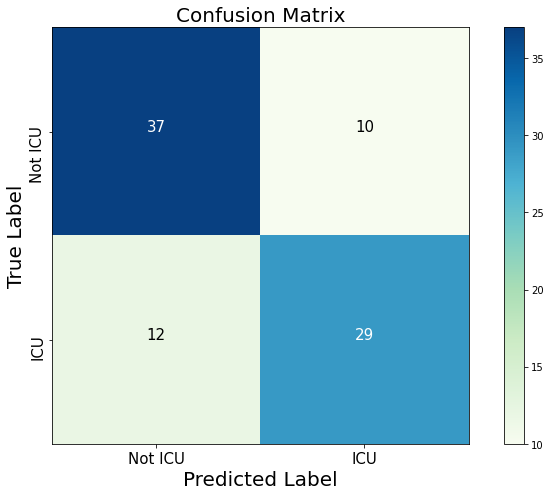

In [ ]:
confusion_matrix_plot(y_prediction_lgb)

In [ ]:
# single auc
prob_lgbm = lgb_model.predict_proba(X_test)
lgb_auc = roc_auc_score(y_test, prob_rfc[:,1])
lgb_auc

0.856772184743124

In [ ]:
# time taken: 22 minutes
# run_cv_model(lgb_model, data_ml, 5, 2)

Average AUC Score: 0.7800572627052891

AUC 95% Confidence Interval: 0.6672284392238399 to 0.8928860861867383

In [ ]:
# to save it in a variable
# instead of waiting 22 minutes for the model to run
lgb_avg_auc =  0.7800572627052891 

[]

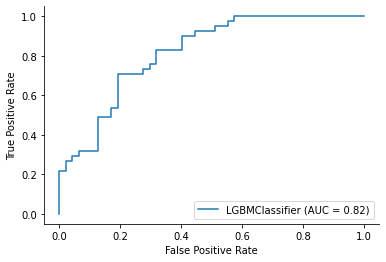

In [ ]:
plot_roc_curve(lgb_model, X_test, y_test)
sns.despine()
plt.plot()

In [ ]:
lgb_dict = classification_report(y_test, y_prediction_lgb, output_dict = True)
print(classification_report(y_test, y_prediction_lgb))

              precision    recall  f1-score   support

           0       0.76      0.79      0.77        47
           1       0.74      0.71      0.72        41

    accuracy                           0.75        88
   macro avg       0.75      0.75      0.75        88
weighted avg       0.75      0.75      0.75        88



<a name="abc"></a>
## 6.5 Model 5: AdaBoostClassifier

From the documentation:

> An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

_Source:_ [AdaBoostClassifier Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

### Default Model

In [ ]:
abc_model = AdaBoostClassifier()
abc_model.fit(X_train, y_train)

y_prediction_abc = abc_model.predict(X_test)
accuracy_score(y_test, y_prediction_abc)

0.7613636363636364

### Tuned Model

In [ ]:
abc_model = AdaBoostClassifier()

params = {
    'n_estimators': [10, 50, 100, 250],
    'random_state': [rs],
    'learning_rate': [0.01, 0.1, 0.3, 1]
}

abc_search = GridSearchCV(abc_model,
                          params, 
                          scoring = 'roc_auc',
                          error_score = 'raise',
                          n_jobs = -1,
                          verbose = 0,
                          cv = 5)

abc_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise', estimator=AdaBoostClassifier(),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 1],
                         'n_estimators': [10, 50, 100, 250],
                         'random_state': [84097]},
             scoring='roc_auc')

In [ ]:
abc_search.best_params_

{'learning_rate': 0.01, 'n_estimators': 250, 'random_state': 84097}

In [ ]:
abc_model = abc_search.best_estimator_
abc_model.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.01, n_estimators=250, random_state=84097)

### Metrics

In [ ]:
y_prediction_abc = abc_model.predict(X_test)
abc_accuracy = accuracy_score(y_test, y_prediction_abc)
print(f'The accuracy of the AdaBoostMetric is {abc_accuracy}.')

The accuracy of the AdaBoostMetric is 0.7272727272727273.


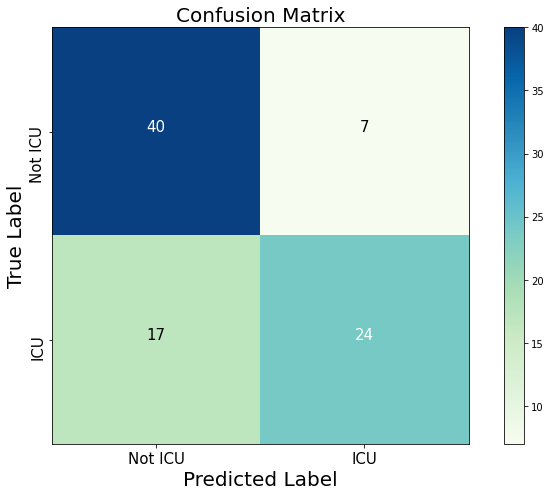

In [ ]:
confusion_matrix_plot(y_prediction_abc)

In [ ]:
# singl auc
prob_abc = abc_model.predict_proba(X_test)
abc_roc = roc_auc_score(y_test, prob_abc[:,1])
abc_roc

0.7854177477944992

In [ ]:
# average auc with cross validation
run_cv_model(abc_model, data_ml, 5, 2)

Average AUC Score: 0.7513939515173067
AUC 95% Confidence Interval: 0.6475759499882963 to 0.8552119530463171


In [ ]:
# to save it in a variable
abc_avg_auc = 0.7513939515173067

[]

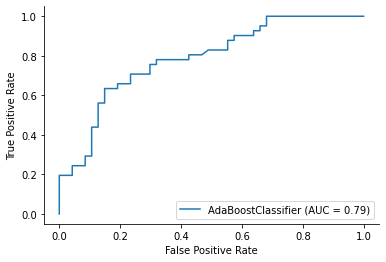

In [ ]:
plot_roc_curve(abc_model, X_test, y_test)
sns.despine()
plt.plot()

In [ ]:
abc_dict = classification_report(y_test, y_prediction_abc, output_dict = True)
print(classification_report(y_test, y_prediction_abc))

              precision    recall  f1-score   support

           0       0.70      0.85      0.77        47
           1       0.77      0.59      0.67        41

    accuracy                           0.73        88
   macro avg       0.74      0.72      0.72        88
weighted avg       0.74      0.73      0.72        88



<a name="logit"></a>
## 6.6 Model 6: Logistic Regression

From the documentation:

> Logistic regression, despite its name, is a linear model for classification rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

_Source:_ [Logistic Regression Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) 

### Default Model

In [ ]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

y_prediction_lr = lr_model.predict(X_test)
accuracy_score(y_test, y_prediction_lr)

0.7272727272727273

### Tuned Model

In [ ]:
grid = {
    "C": np.logspace(-4, 50, 50),
    "penalty": ["l1", "l2"]
    }

lr_model = LogisticRegression()
lr_search = GridSearchCV(lr_model, grid, cv = 10, scoring = 'roc_auc')
lr_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.26485522e-03, 1.59985872e-02, 2.02358965e-01,
       2.55954792e+00, 3.23745754e+01, 4.09491506e+02, 5.17947468e+03,
       6.55128557e+04, 8.28642773e+05, 1.04811313e+07, 1.32571137e+08,
       1.67683294e+09, 2.12095089e+10, 2.68269580e+11, 3.39322177e+12,
       4.29193426e+13, 5.42867544e+14, 6.86648...
       7.19685673e+26, 9.10298178e+27, 1.15139540e+29, 1.45634848e+30,
       1.84206997e+31, 2.32995181e+32, 2.94705170e+33, 3.72759372e+34,
       4.71486636e+35, 5.96362332e+36, 7.54312006e+37, 9.54095476e+38,
       1.20679264e+40, 1.52641797e+41, 1.93069773e+42, 2.44205309e+43,
       3.08884360e+44, 3.90693994e+45, 4.94171336e+46, 6.25055193e+47,
       7.90604321e+48, 1.00000000e+50]),
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [ ]:
lr_model = lr_search.best_estimator_
lr_model.fit(X_train, y_train)

LogisticRegression(C=0.20235896477251555)

### Metrics

In [ ]:
y_prediction_lr = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_prediction_lr)
print(f'The accuracy for the Logistic Regression model is {lr_accuracy}.')

The accuracy for the Logistic Regression model is 0.7272727272727273.


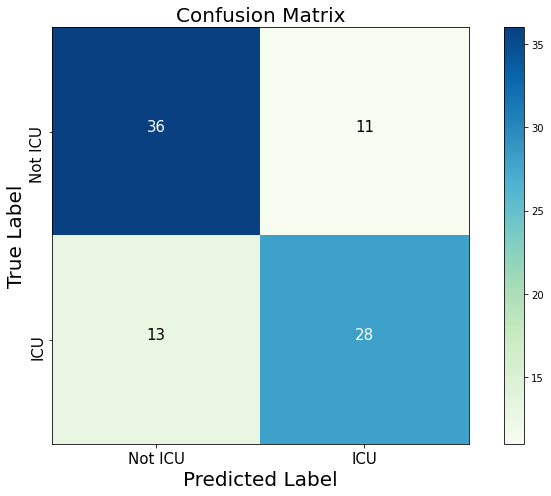

In [ ]:
confusion_matrix_plot(y_prediction_lr)

In [ ]:
# single auc
prob_lr = lr_model.predict_proba(X_test)
lr_auc = roc_auc_score(y_test, prob_lr[:,1])
lr_auc

0.8147379346133887

In [ ]:
# average auc from cross validation
run_cv_model(lr_model, data_ml, 5, 2)

Average AUC Score: 0.76443037684814
AUC 95% Confidence Interval: 0.6365981892543888 to 0.8922625644418911


In [ ]:
# to save it
lr_avg_auc = 0.76443037684814

[]

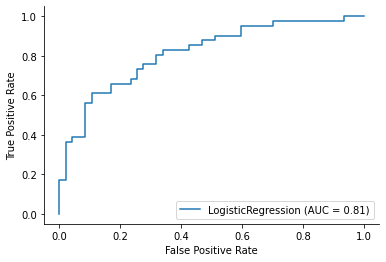

In [ ]:
plot_roc_curve(lr_model, X_test, y_test)
sns.despine()
plt.plot()

In [ ]:
lr_dict = classification_report(y_test, y_prediction_lr, output_dict = True)
print(classification_report(y_test, y_prediction_lr))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75        47
           1       0.72      0.68      0.70        41

    accuracy                           0.73        88
   macro avg       0.73      0.72      0.72        88
weighted avg       0.73      0.73      0.73        88



<a name="xgboost"></a>
## 6.7 Model 7: XGBoost Classifier

From the documentation:

> XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.

_Source:_ [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/)

### Default Model

In [ ]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

y_prediction_xgb = xgb_model.predict(X_test)
accuracy_score(y_test, y_prediction_xgb)

0.6931818181818182

### Tuned Model

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'n_estimators': [100, 250, 1000, 2000],
        'learning_rate': [0.01, 0.1, 0.3, 1]
        }

xgb_model = XGBClassifier(learning_rate = 0.02,
                          nthread = 1)

skf = StratifiedKFold(n_splits = 5,
                      shuffle = True,
                      random_state = rs)

xgb_search = RandomizedSearchCV(xgb_model,
                                   param_distributions = params,
                                   n_iter = 5,
                                   scoring = 'roc_auc',
                                   n_jobs = 100,
                                   cv = skf.split(X_train, y_train),
                                   verbose = 0,
                                   random_state = rs)

xgb_search.fit(X_train, y_train)

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fbcd1701850>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.02,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                           verbosity=None),
                   n_iter=5, n_jobs=100,
                  

In [ ]:
xgb_search.best_params_

{'colsample_bytree': 1.0,
 'gamma': 0.5,
 'learning_rate': 0.3,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 2000,
 'subsample': 0.8}

In [ ]:
xgb_model = xgb_search.best_estimator_
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

### Metrics

In [ ]:
y_prediction_xgb = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_prediction_xgb)
print(f'The accuracy for the XGBoostClassifier model is {xgb_accuracy}.')

The accuracy for the XGBoostClassifier model is 0.75.


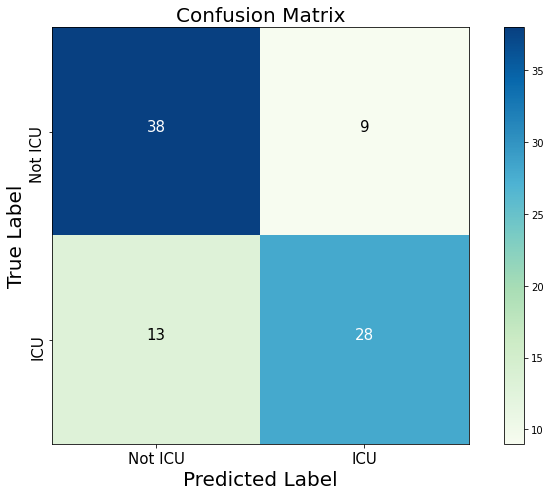

In [ ]:
confusion_matrix_plot(y_prediction_xgb)

In [ ]:
# single auc
prob_xgb = xgb_model.predict_proba(X_test)
xgb_auc = roc_auc_score(y_test, prob_xgb[:,1])
xgb_auc

0.8500259470679813

In [ ]:
# average auc with cross validation
run_cv_model(xgb_model, data_ml, 5, 2)

Average AUC Score: 0.7747947109789214
AUC 95% Confidence Interval: 0.6402747689687943 to 0.9093146529890485


In [ ]:
# to save it
xgb_avg_auc = 0.7747947109789214

[]

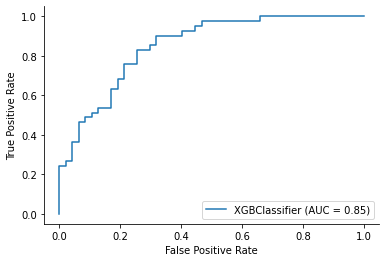

In [ ]:
plot_roc_curve(xgb_model, X_test, y_test)
sns.despine()
plt.plot()

In [ ]:
xgb_dict = classification_report(y_test, y_prediction_xgb, output_dict = True)
print(classification_report(y_test, y_prediction_xgb))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78        47
           1       0.76      0.68      0.72        41

    accuracy                           0.75        88
   macro avg       0.75      0.75      0.75        88
weighted avg       0.75      0.75      0.75        88



<a name="best"></a>
# 7 Best Models and Validations

We will know take a look at which models best performed on our chosen metric (F1-score).

After that, we pick the two best models to check their feature importance. And then we'll make the ICU prediction based on the results of the first model with best metric.

<a name="summ"></a>
## 7.1 Models Summary

In [ ]:
dummy_metrics = organize_metrics('dummy')
rfc_metrics = organize_metrics('rfc')
lgb_metrics = organize_metrics('lgb')
abc_metrics = organize_metrics('abc')
lr_metrics = organize_metrics('lr')
xgb_metrics = organize_metrics('xgb')

In [ ]:
metrics_dict = {
    'Model_Name': ['Accuracy', 'Average AUC', 'F1-score 0', 'F1-score 1',
                   'Precision 0', 'Precision 1', 'Recall 0', 'Recall 1'],
    'DummyClassifier': dummy_metrics,
    'RandomForestClassifier': rfc_metrics,
    'LGBMClasssifier': lgb_metrics,
    'AdaBoostClassifier': abc_metrics,
    'LogisticRegression': lr_metrics,
    'XGBoostClassifier': xgb_metrics
}

metrics_df = pd.DataFrame(metrics_dict)
metrics_df.set_index('Model_Name').T.sort_values(by = 'F1-score 1', ascending = False)

Model_Name,Accuracy,Average AUC,F1-score 0,F1-score 1,Precision 0,Precision 1,Recall 0,Recall 1
LGBMClasssifier,0.75,0.78,0.77,0.72,0.76,0.74,0.79,0.71
XGBoostClassifier,0.75,0.77,0.78,0.72,0.75,0.76,0.81,0.68
RandomForestClassifier,0.74,0.80,0.77,0.70,0.73,0.75,0.81,0.66
LogisticRegression,0.73,0.76,0.75,0.70,0.73,0.72,0.77,0.68
AdaBoostClassifier,0.73,0.75,0.77,0.67,0.70,0.77,0.85,0.59
DummyClassifier,0.53,0.50,0.70,0.00,0.53,0.00,1.00,0.00


Our chosen model would need a good F1-score on the class 1 (the ICU class).

Looking at our table, we see that the top 2 models on this metric are
- **LGBMClassifier** and
- **XGBoostClassifier**.

By checking, for example, the Precision 1, XGBoostClassifier also performs well, as well as having more accuracy that most models.

<a name="feat"></a>
## 7.2 Feature Importance

### XGBoostClassifier

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


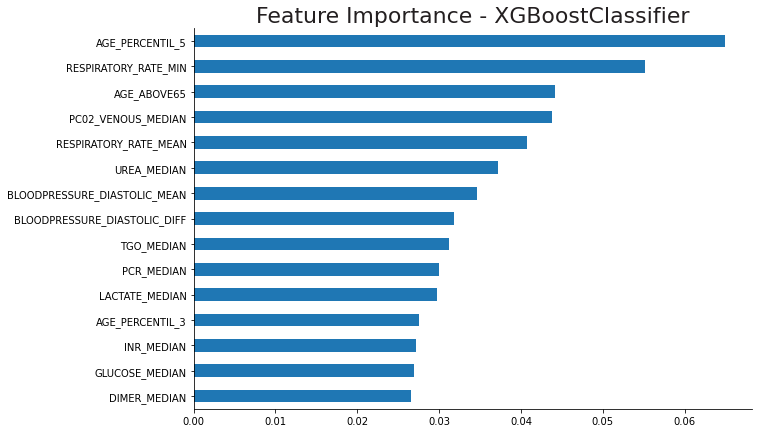

In [ ]:
feat_import_xgb = pd.Series(xgb_model.feature_importances_, index = X_train.columns)
ax = feat_import_xgb.nlargest(15).sort_values(ascending = True).plot(kind = 'barh',
                                                                      figsize = (10, 7))
plt.title('Feature Importance - XGBoostClassifier', fontsize = 22, color = GRAY1)
sns.despine()
plt.show()

**Does this make sense?**

Let's see:

The most important feature that XGBoostClassifier takes into account when modelling is ```AGE_PERCENTIL_5```. This variable represents people with ages between 60 and 70 years. This makes sense, since we all know that old age is a risk factor in COVID-19. And we also checked that in our exploratory data analysis and we've seen that people past a certain age need more ICU beds.

_Source:_ [ICU outcomes and survival in patients with severe COVID-19](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0249038)

From the above article:

> Out of total of 1283 patients with COVID-19, 131 (10.2%) met criteria for ICU admission (**median age: 61 years** [interquartile range (IQR), 49.5–71.5]; 35.1% female).

This correlates with our findings.

The second most important feature is ```RESPIRATORY_RATE_MEAN```. Since COVID-19 also attacks the respiratory system, of course this feature is relevant in the ICU prediction.

Another important feature is ```PCO2_VENOUS```.

> Venous pCO2 was significantly higher whereas pO2 and sO2 were significantly lower in patients who tested positive for SARS-CoV-2.

_Source:_ [Venous blood gas analysis in patients with COVID-19 symptoms](https://www.degruyter.com/document/doi/10.1515/labmed-2020-0126/html)

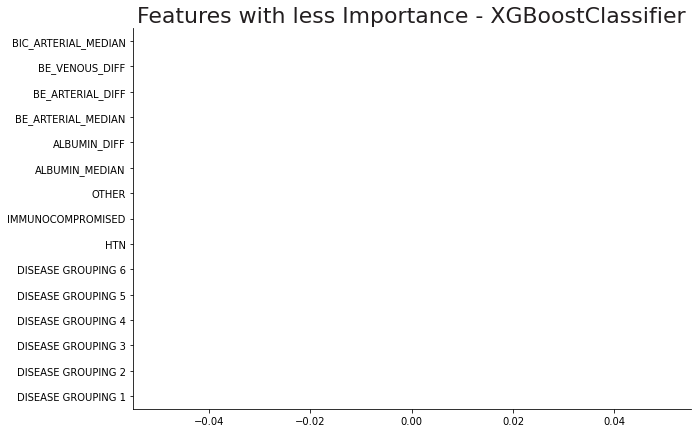

In [ ]:
feat_import_xgb = pd.Series(xgb_model.feature_importances_, index = X_train.columns)
ax = feat_import_xgb.nsmallest(15).sort_values(ascending = True).plot(kind = 'barh',
                                                                      figsize = (10, 7))
plt.title('Features with less Importance - XGBoostClassifier', fontsize = 22, color = GRAY1)
sns.despine()
plt.show()

Looking at the features that have less importance, we have the disease groupings. This is surprising and goes against the actual understanding that certain diseases increase the risk of hospitalization for COVID-19.

### LGBMClassifier

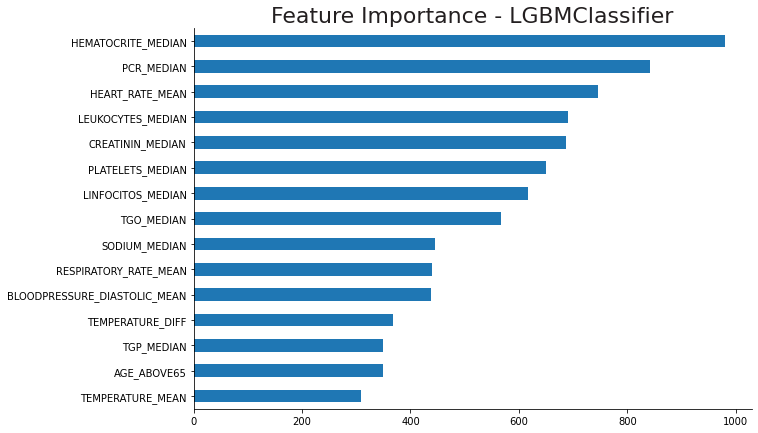

In [ ]:
feat_import_lgb = pd.Series(lgb_model.feature_importances_, index = X_train.columns)
ax = feat_import_lgb.nlargest(15).sort_values(ascending = True).plot(kind = 'barh',
                                                                      figsize = (10, 7))
plt.title('Feature Importance - LGBMClassifier', fontsize = 22, color = GRAY1)
sns.despine()
plt.show()

Here, in the LGBMClassifier, we have different features appearing as the most important for the model.

The first feature, ```HEMATOCRITE```, also known as HCT, has been studied and found to be reduced in patients with COVID-19.

> Our analysis has found lower HGB (124.84 ± 15.877) and reduced HCT (37.45 ± 4.685) [...]

_Source:_ [Blood routine test in mild and common 2019 coronavirus (COVID-19) patients](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7414516/)

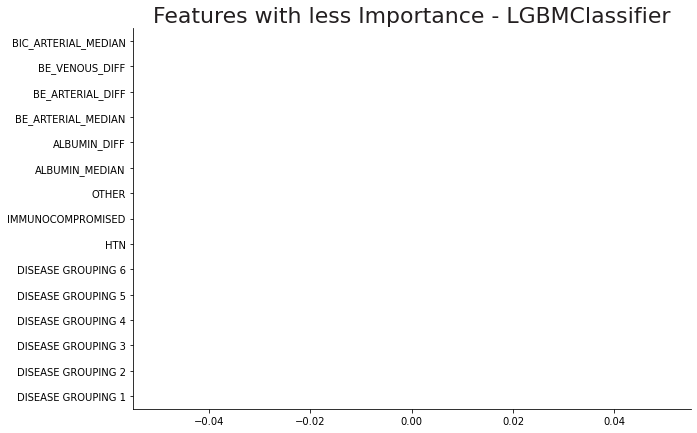

In [ ]:
feat_import_lgb = pd.Series(lgb_model.feature_importances_, index = X_train.columns)
ax = feat_import_lgb.nsmallest(15).sort_values(ascending = True).plot(kind = 'barh',
                                                                      figsize = (10, 7))
plt.title('Features with less Importance - LGBMClassifier', fontsize = 22, color = GRAY1)
sns.despine()
plt.show()

Again, we have that the disease groupings have no effect in the machine learning model.

<a name="icu"></a>
## 7.3 ICU Prediction

Looking at our table:

In [ ]:
metrics_df.set_index('Model_Name').T.sort_values(by = 'F1-score 1', ascending = False)

Model_Name,Accuracy,Average AUC,F1-score 0,F1-score 1,Precision 0,Precision 1,Recall 0,Recall 1
LGBM Classsifier,0.75,0.78,0.77,0.72,0.76,0.74,0.79,0.71
XGBoostClassifier,0.75,0.77,0.78,0.72,0.75,0.76,0.81,0.68
RandomForestClassifier,0.74,0.80,0.77,0.70,0.73,0.75,0.81,0.66
LogisticRegression,0.73,0.76,0.75,0.70,0.73,0.72,0.77,0.68
AdaBoostClassifier,0.73,0.75,0.77,0.67,0.70,0.77,0.85,0.59


And with our findings up to this point, the chosen model for the ICU prediction will be LGBMClassifier.

We already have its prediction in the variable ```y_prediction_lgb```. Let's check it out.

In [ ]:
icu_predictions = pd.DataFrame()
icu_predictions['True_Value'] = y_test
icu_predictions['Predicted_Values'] = y_prediction_lgb
icu_predictions.head(15)

,True_Value,Predicted_Values
242,1,1
172,1,1
294,1,0
266,1,1
25,1,1
42,0,1
92,1,0
194,1,1
131,0,1
124,1,0


So now we have a prediction together with the patient identifier.

The confusion matrix for this is:

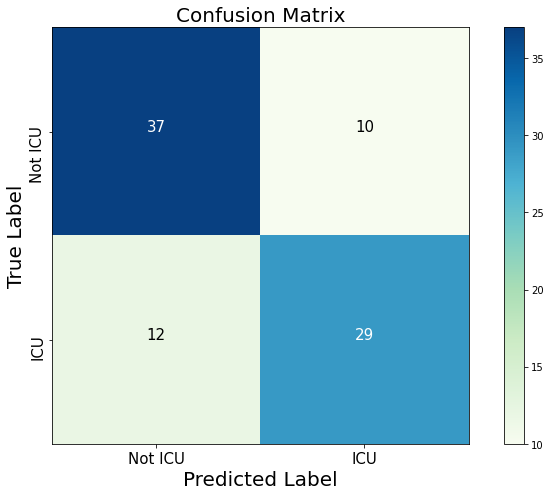

In [ ]:
confusion_matrix_plot(y_prediction_lgb)

<a name="conc"></a>
# 8 What can we conclude from this project?

COVID-19 has taken an enormous toll on healthcare systems all around the globe. Healthcare professionals are overworked and this raises the need for a helping hand. This can be achieved in the form of Machine Learning models used to predict the need for ICU beds for COVID-19 patients.

In this project we have seen that this is possible, but this tool can never be used alone (unless its predictions were right 100% of the time, but we're far from a model that achieves that). There needs to be a healthcare professional with better judgement than our models to assess the need for ICU admission.

<a name="next"></a>
# 9 Going Forward...

For next projects, better hyperparameter tuning could lead to improved results and predictions.

This project could also be applied to other diseases, with the appropriate care and adaptations.

An interesting idea could be to implement a web app (for example, a Streamlit application) that receives the relevant information for a patient (or for a group of patients) and returns the prediction for the need of said patient to go to the ICU. It could also output a confidence value for that prediction, so healthcare professionals could take a closer look at patients in which the model could not predict very well.

<a name="refs"></a>
# 10 References

For the most part, I used the documentation of the following libraries:

- [Pandas](https://pandas.pydata.org/)
- [Matplotlib](https://matplotlib.org/)
- [Numpy](https://numpy.org/)
- [Seaborn](https://seaborn.pydata.org/)
- [Scikit-Learn](https://scikit-learn.org/stable/)
- [Lazy Predict](https://lazypredict.readthedocs.io/en/latest/readme.html#usage)

Articles and posts that helped this project:

- [COVID-19 - Clinical Data to assess diagnosis (Kaggle)](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19)
- [Tour of Evaluation Metrics for Classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)
- [ICU outcomes and survival in patients with severe COVID-19](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0249038)
- [Venous blood gas analysis in patients with COVID-19 symptoms](https://www.degruyter.com/document/doi/10.1515/labmed-2020-0126/html)
- [Blood routine test in mild and common 2019 coronavirus (COVID-19) patients](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7414516/)
- [Predicting the Need for ICU Admission in COVID-19 Patients Using XGBoost](https://www.techscience.com/cmc/v69n2/43880/html)
- [Using machine learning tools to predict outcomes for emergency department intensive care unit patients](https://www.nature.com/articles/s41598-020-77548-3)
- [Comparing machine learning algorithms for predicting ICU admission and mortality in COVID-19](https://www.nature.com/articles/s41746-021-00456-x)
- [Machine Learning Approach to Predicting COVID-19 Disease Severity](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8045777/)
- [Useful Metrics to Evaluate Binary Classification Models](https://thedigitalskye.com/2021/04/19/6-useful-metrics-to-evaluate-binary-classification-models/)
- [Metrics to Evaluate your Machine Learning Algorithm](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234)
- [How to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

<a name="cont"></a>
# 11 Contacts

Feel free to contact me for any questions or suggestions:

- E-mail: carolinadiasw@gmail.com
- Linkedin: https://linkedin/in/carodias